## Cluster Analysis
This book comprises a cluster analyis of the complete dataset (original) and its derived datasets (Influencers_OLS, OLS_all and uniques23 and uniques23_50), as defined in earlier notebooks. The pipeline applied is described below:

__Data Preparation:__  
    Only scaling and normalization were applied, as data cleaning was already performed in earlier steps.  
__Dimensionality Reduction:__  
    Principal Component Analysis (PCA) was used to reduce dimensionality while retaining approximately 90% of the variance.  
    This step resulted in transformed datasets with reduced feature dimensions, which were subsequently used for clustering.  
__Clustering Analysis:__  
    Clustering was performed on the transformed datasets using:   
    K-Means, with k=5 determined by the elbow method.  
    DBSCAN, for detecting clusters and outliers.  
    Gaussian Mixture Models (GMM), to capture potential non-linear structures.  
__Performance evaluation included:__   
    Internal metrics, such as Silhouette Score and Davies-Bouldin Index.  
    External metrics (where labels were available), including Adjusted Rand Index (ARI) and Homogeneity Score.  

In [177]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import adjusted_rand_score
from umap import UMAP
import umap.umap_ as umap
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder

MinMaxScaler is the denominated scaler that owe to be used with this data since doesnt have gaussian distribution, however it does only work well for DBSCAN, so the StandarScaler is use in conjuction with the KMeans cluster analysis. First pipeline Scales, and reduce the dimensionality with PCA to 90% varianza, then uses 3 clustering methods( K-Means, DBSCAN, and GMM) applied on PCA-reduced data. Evaluation of the methods uses following metrics: Silhouette Score and Davies-Bouldin Index for internal evaluation. Adjusted Rand Index (ARI) for external evaluation since true labels are present.

In [141]:
#Loading the data 
pd.options.display.float_format = '{:.4f}'.format
# Read the excel file
Jointax = pd.read_excel('data/Jointax.xlsx', sheet_name='Biotot_jointax', header=[0,1,2,3,4,5,6,7] , dtype={**{i: str for i in range(0,2)},
                                                                        **{i:float for i in range(2, 884)}},  skiprows=[8]) # Somehow it was showing an empty row, so skiprow deletes it
old_new1  = pd.read_excel(f'data/old_new_data.xlsx', sheet_name='old_new1')
old_new2  = pd.read_excel(f'data/old_new_data.xlsx', sheet_name='old_new2')

original_pca  = pd.read_excel(f'data/df_after_pca.xlsx', sheet_name='original_pca')

Influencers_uniques = pd.read_excel(f'data/df_after_pca.xlsx', sheet_name='Influencers_uniques')

combined = pd.read_excel(f'data/df_after_pca.xlsx', sheet_name='merged')

OLS_all = pd.read_excel('data/OLS_all.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}}) 
Influencers_OLS = pd.read_excel('data/Influencers_OLS.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})

In [142]:
# Making sure the sites and categories get read as they should
Jointax["Sites"]= Jointax["Sites"].astype(str)
Jointax["Category"]= Jointax["Category"].values.astype(int)
#Drop level of Kindom since it is boring
Jointax.columns = Jointax.columns.droplevel(1)
Jointax = Jointax.reset_index(drop=True)
#Setting the sites as index
Jointax = Jointax.set_index("Sites").reset_index()
# Deleting headers names of unnamed levels
Jointax.columns = Jointax.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
#Drop column 1
Jointax =Jointax.drop(Jointax.columns[1], axis=1)
#Correcting the Tuple-like Index
Jointax['Sites'] = Jointax['Sites'].map(lambda x: x[0] if isinstance(x, tuple) else x)
Jointax = Jointax.set_index("Sites")

In [143]:
# We working only with the values in this notebook, still keeping the taxa 
Jointax.columns = Jointax.columns.droplevel([0,1,2,3,4,5])
original = Jointax.reset_index(drop=False)
#Reset the index
if original.columns[1] == "":
    original.rename(columns = {original.columns[1]: "Category"}, inplace=True)
original= original.set_index("Sites")

In [144]:
def clean_dataframe(df):
    # Check if 'Unnamed: 0' exists before dropping
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns='Unnamed: 0', axis=1)
    return df.astype({'Sites': str, 'Category': int}).set_index("Sites")

original_pca = clean_dataframe(original_pca)
OLS_all = clean_dataframe(OLS_all)
Influencers_OLS = clean_dataframe(Influencers_OLS)
Influencers_uniques = clean_dataframe(Influencers_uniques)
combined= clean_dataframe(combined)
old_new1= clean_dataframe(old_new1)
old_new2= clean_dataframe(old_new2)

In [145]:
def clustering_pipeline_all(df, pca_data_name='pca_data', n_clusters=5, eps=0.5, min_samples=5, n_components=2):
    """
    Performs clustering using K-Means, DBSCAN, and GMM with PCA for dimensionality reduction.
    
    Parameters:
    - df: Input DataFrame (features only, no labels).
    - n_clusters: Number of clusters for K-Means and GMM (default=5).
    - eps: DBSCAN's epsilon parameter (default=0.5).
    - min_samples: Minimum samples for DBSCAN (default=5).
    - n_components: Number of components for PCA (default=2).
    
    Returns:
    - results: Dictionary with clustering results for K-Means, DBSCAN, and GMM, as well as PCA data and metrics.
    """
    results = {}
    # Ensuring feature names are preserved
    original_columns = df.columns
    df = df.copy()  # avoid modifications to original

    # Separate true labels
    true_labels = df['Category']

    df = df.drop(columns=['Category'])  # Drop any non-numeric columns

    # Step 1: Scaling the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    
    # Step 2: PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(scaled_data)

    # Calculate explained variance and cumulative variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    # Clustering
    results = {
        'pca': pca,
        'pca_data_name': pca_data,
        'scaled_data': scaled_data,
        'explained_variance': explained_variance_ratio,
        'cumulative_variance': cumulative_variance_ratio
    }

    # Step 3: K-Means Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(pca_data)
    kmeans_silhouette = silhouette_score(pca_data, kmeans_labels)
    kmeans_db_score = davies_bouldin_score(pca_data, kmeans_labels)
    kmeans_ari = adjusted_rand_score(true_labels, kmeans_labels)

    results['kmeans'] = {
        'cluster_labels': kmeans_labels,
        'silhouette_score': kmeans_silhouette,
        'davies_bouldin_score': kmeans_db_score,
        'adjusted_rand_score': kmeans_ari
    }
    
    # Step 4: DBSCAN Clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Add automatic eps calculation if not provided
    if eps is None:
        nbrs = NearestNeighbors(n_neighbors=2).fit(scaled_data)
        distances, _ = nbrs.kneighbors(scaled_data)
        eps = np.percentile(distances[:, 1], 90)

    dbscan_labels = dbscan.fit_predict(pca_data)
    valid_indices = dbscan_labels != -1
    if len(set(dbscan_labels[valid_indices])) > 1:
        dbscan_silhouette = silhouette_score(pca_data[valid_indices], dbscan_labels[valid_indices])
        dbscan_db_score = davies_bouldin_score(pca_data[valid_indices], dbscan_labels[valid_indices])
    else:
        dbscan_silhouette = None
        dbscan_db_score = None
    dbscan_ari = adjusted_rand_score(true_labels, dbscan_labels)


    results['dbscan'] = {
        'cluster_labels': dbscan_labels,
        'silhouette_score': dbscan_silhouette,
        'davies_bouldin_score': dbscan_db_score,
        'adjusted_rand_score': dbscan_ari
    }
    
    # Step 5: GMM Clustering
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(pca_data)
    gmm_silhouette = silhouette_score(pca_data, gmm_labels)
    gmm_db_score = davies_bouldin_score(pca_data, gmm_labels)
    gmm_ari = adjusted_rand_score(true_labels, gmm_labels)
    
    results['gmm'] = {
        'cluster_labels': gmm_labels,
        'silhouette_score': gmm_silhouette,
        'davies_bouldin_score': gmm_db_score,
        'adjusted_rand_score': gmm_ari,
        'bic_score': gmm.bic(pca_data),
        'aic_score': gmm.aic(pca_data)
    }

    # Addind normalized metrics
    for method in ['kmeans', 'dbscan', 'gmm']:
        labels = results[method]['cluster_labels']
        if method == 'dbscan':
            valid_labels = labels[labels != -1]
            sizes = np.bincount(valid_labels)
        else:
            sizes = np.bincount(labels)
        results[method]['normalized_sizes'] = sizes / len(labels)

    # Store PCA-transformed data with the specified name
    results[pca_data_name] = pca_data
    
    return results

## Visualisation K-means, DBSCAN AND GaussianMixture

In [149]:
def visualize_clustering_results(results, title_prefix=''):
    """
    Visualize clustering results with multiple plots and metrics
    
    Parameters:
    - results: Dictionary containing clustering results from clustering_pipeline_all function
    - title_prefix: Optional prefix for plot titles
    """
    # Extract PCA data
    pca_data = results[list(filter(lambda x: x.startswith('pca_'), results.keys()))[0]]
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{title_prefix}Clustering Results Visualization', fontsize=16)

    # plot style settings for better visibility
    plt.style.use('seaborn')
    
    # Color palettes for different clustering methods
    color_palettes = [
        sns.color_palette("husl", n_colors=len(np.unique(results['kmeans']['cluster_labels']))),
        sns.color_palette("seismic", n_colors=len(np.unique(results['dbscan']['cluster_labels']))),
        sns.color_palette("deep", n_colors=len(np.unique(results['gmm']['cluster_labels'])))
    ]

    # Add grid for better readability
    for ax in axs.flat:
        ax.grid(True, alpha=0.3)
    
    # Clustering methods and their labels
    clustering_methods = [
        ('K-Means', results['kmeans']['cluster_labels'], color_palettes[0]),
        ('DBSCAN', results['dbscan']['cluster_labels'], color_palettes[1]),
        ('Gaussian Mixture Model', results['gmm']['cluster_labels'], color_palettes[2])
    ]
    
    # Scatter plots for each clustering method
    for idx, (method_name, labels, color_palette) in enumerate(clustering_methods):
        row = idx // 2
        col = idx % 2
        
        # Handle DBSCAN noise points
        if method_name == 'DBSCAN':
            noise_mask = labels == -1
            cluster_mask = labels != -1
            
            # Plot noise points
            if np.any(noise_mask):
                axs[row, col].scatter(
                    pca_data[noise_mask, 0], 
                    pca_data[noise_mask, 1], 
                    c='gray', 
                    alpha=0.5, 
                    label='Noise'
                )
            
            # Plot clustered points
            unique_labels = np.unique(labels[cluster_mask])
            for label in unique_labels:
                mask = (labels == label) & cluster_mask
                axs[row, col].scatter(
                    pca_data[mask, 0], 
                    pca_data[mask, 1], 
                    c=[color_palette[label]], 
                    label=f'Cluster {label}'
                )
        else:
            # For K-Means and GMM
            unique_labels = np.unique(labels)
            for label in unique_labels:
                mask = labels == label
                axs[row, col].scatter(
                    pca_data[mask, 0], 
                    pca_data[mask, 1], 
                    c=[color_palette[label]], 
                    label=f'Cluster {label}'
                )
        
        axs[row, col].set_title(f'{method_name} Clustering')
        axs[row, col].set_xlabel('First Principal Component')
        axs[row, col].set_ylabel('Second Principal Component')
        axs[row, col].legend()
    
    plt.tight_layout()
    plt.show()

def print_clustering_metrics(results):
    """
    Print detailed clustering metrics for each method
    
    Parameters:
    - results: Dictionary containing clustering results
    """
    print("\n=== Clustering Metrics ===")
    
    # Cluster quality metrics
    def calculate_cluster_quality(labels, data):
        if len(set(labels)) <= 1:
            return None
        # Calculate average intra-cluster distance
        intra_cluster_distances = []
        for label in set(labels):
            if label != -1:  # Skip noise points
                cluster_points = data[labels == label]
                if len(cluster_points) > 1:
                    distances = pdist(cluster_points)
                    intra_cluster_distances.append(np.mean(distances))
        return np.mean(intra_cluster_distances) if intra_cluster_distances else None
    
    # Metrics for each clustering method
    clustering_methods = ['kmeans', 'dbscan', 'gmm']
    
    for method in clustering_methods:
        print(f"\n{method.upper()} Clustering Metrics:")
        labels = results[method]['cluster_labels']
        silhouette = results[method]['silhouette_score']
        db_score = results[method]['davies_bouldin_score']
        ari = results[method].get('adjusted_rand_score', 'N/A')  # Use 'N/A' if ARI is not available
        quality = calculate_cluster_quality(labels, results['scaled_data'])

        if quality is not None:
            print(f"Average Intra-cluster Distance: {quality:.4f}")
        else:
            print("Average Intra-cluster Distance: N/A")
        print(f"Silhouette Score: {silhouette if silhouette is not None else 'Not applicable'}")
        print(f"Davies-Bouldin Score: {db_score if db_score is not None else 'Not applicable'}")
        print(f"Adjusted Rand Score: {ari}")
        
        # Count cluster sizes
        if method == 'dbscan':
            valid_labels = labels[labels != -1]
            unique_labels = np.unique(valid_labels)
        else:
            unique_labels = np.unique(labels)
        
        print("\nCluster Sizes:")
        for label in unique_labels:
            if method == 'dbscan' and label == -1:
                count = np.sum(labels == label)
                print(f"Noise Points: {count}")
            else:
                count = np.sum(labels == label)
                print(f"Cluster {label}: {count} points")

    
    # Print Explained Variance for PCA
    print("\nPCA Explained Variance Ratio:")
    explained_variance = results['explained_variance']
    for i, var in enumerate(explained_variance[:10], 1):
        print(f"PC{i}: {var * 100:.2f}%")
    print(f"Total Variance Explained (first 10 PCs): {np.sum(explained_variance[:10]) * 100:.2f}%")

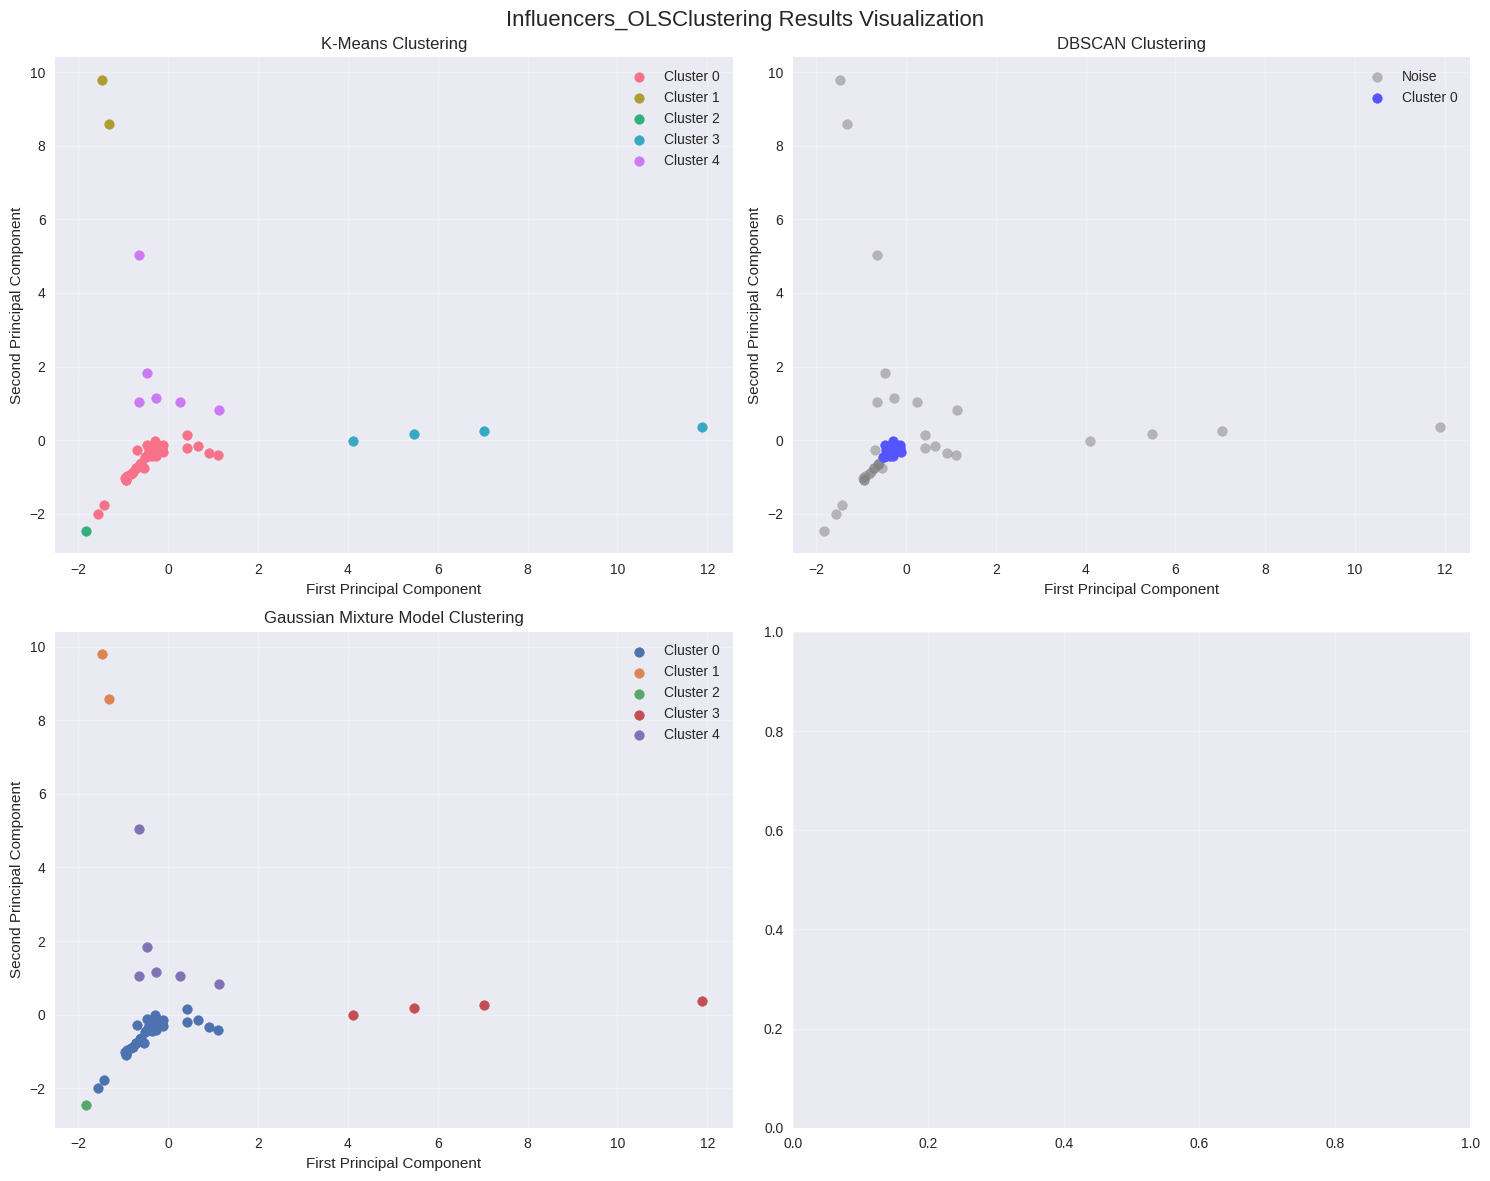


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 5.6651
Silhouette Score: 0.648375314612715
Davies-Bouldin Score: 0.5160419399380063
Adjusted Rand Score: 0.18453461053893616

Cluster Sizes:
Cluster 0: 57 points
Cluster 1: 2 points
Cluster 2: 1 points
Cluster 3: 4 points
Cluster 4: 6 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 0.7151
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.1158484972356072

Cluster Sizes:
Cluster 0: 37 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 5.6651
Silhouette Score: 0.648375314612715
Davies-Bouldin Score: 0.5160419399380063
Adjusted Rand Score: 0.18453461053893616

Cluster Sizes:
Cluster 0: 57 points
Cluster 1: 2 points
Cluster 2: 1 points
Cluster 3: 4 points
Cluster 4: 6 points

PCA Explained Variance Ratio:
PC1: 19.12%
PC2: 16.41%
PC3: 10.92%
PC4: 9.15%
PC5: 6.73%
Total Variance Explained (first 10 PCs): 62.33%


In [150]:
# Running pipeline 
results_Influencers_OLS = clustering_pipeline_all(Influencers_OLS,  pca_data_name='pca_data_Influencers_OLS', 
                                                   n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_Influencers_OLS, title_prefix='Influencers_OLS')
print_clustering_metrics(results_Influencers_OLS)

influencers_OLS:
K-means: Silhouette Score of 0.603, Davies-Bouldin of 0.552
Very imbalanced cluster sizes (1, 53, 3, 3, 10 points)
PCA explains 35.53% of variance

Notice that for PCA visualisation on notebook PCA_RF_FImporance.ipnyb, the same dataset was used, hower the main difference is that there the category label was use to color code the samples, however category was droped and didnt participate on the clustering, it was used just for color coding.
Plots show similar behaviour because the clustering algorithms (K-Means, DBSCAN, GMM) are able to identify the inherent structure in the data and recover groupings that are consistent with the original category information, even though the category column is not provided. it means the clustering methods are effectively capturing the underlying patterns in the data, regardless of whether the category information is explicitly given or not. The consistency between the PCA visualization and the clustering results indicates the data has a clear structure that the algorithms can latch onto.

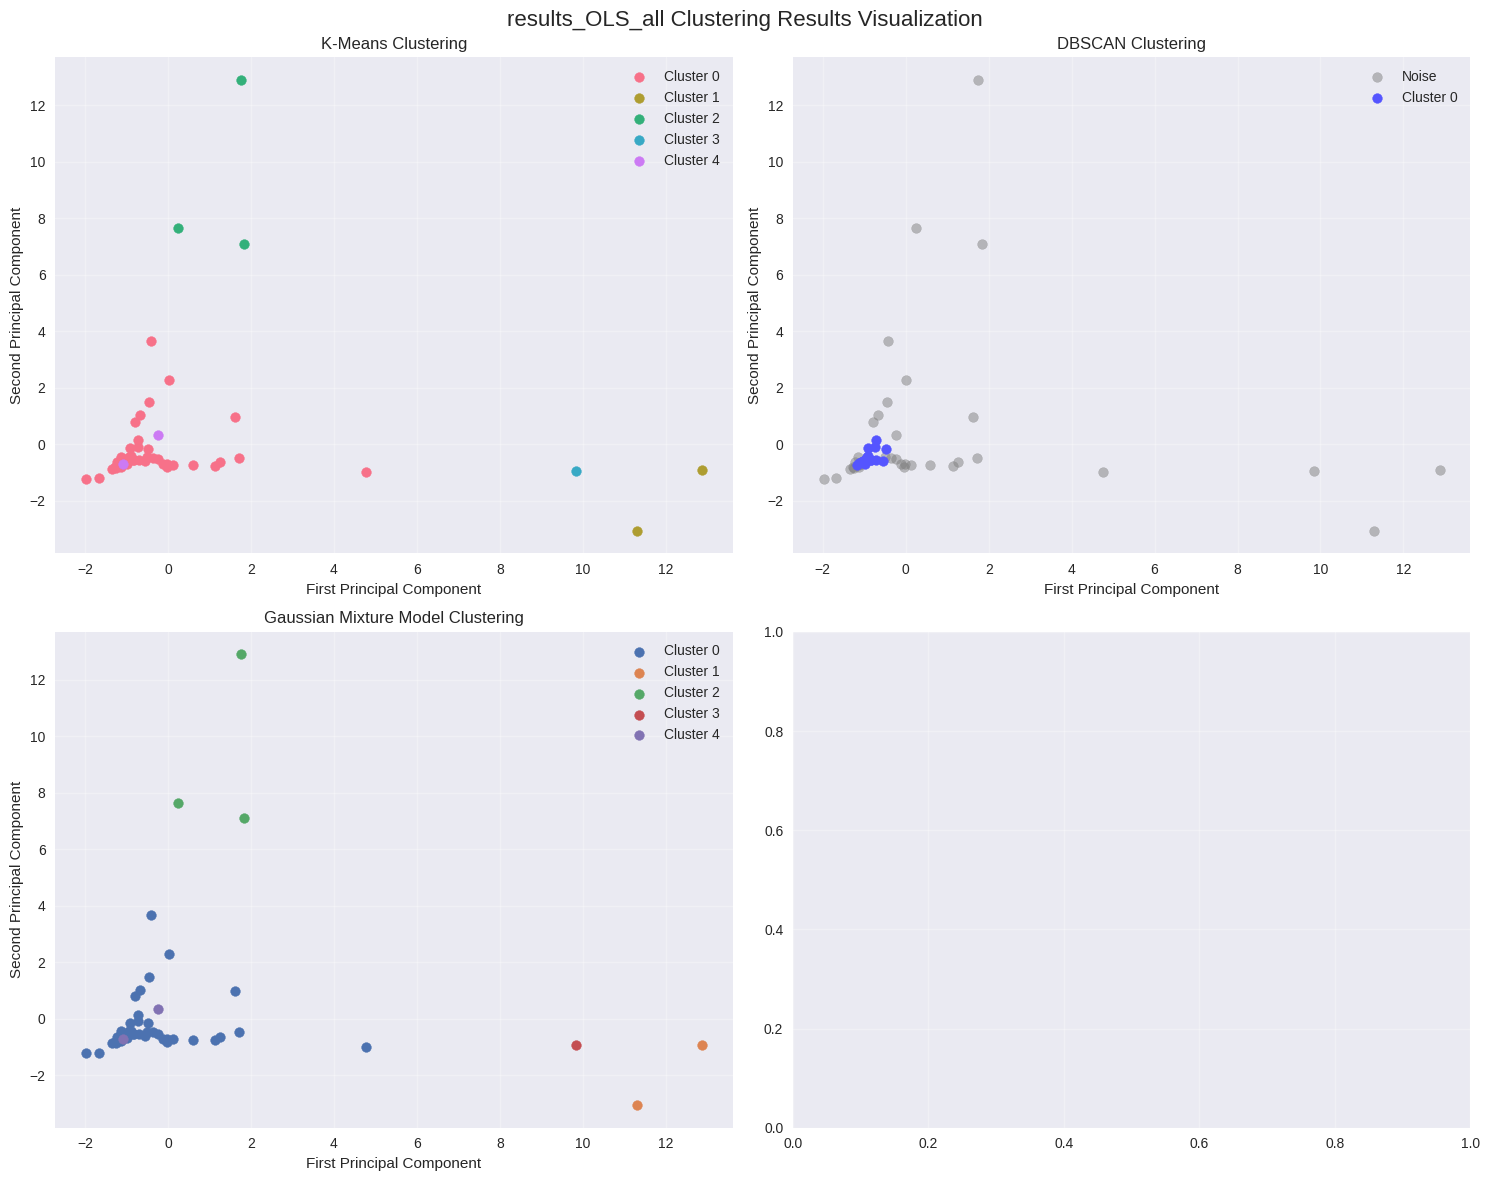


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 8.9253
Silhouette Score: 0.7275569775743765
Davies-Bouldin Score: 0.39104114073843355
Adjusted Rand Score: 0.12140880609088245

Cluster Sizes:
Cluster 0: 62 points
Cluster 1: 2 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 2 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 1.5239
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.11662166071945221

Cluster Sizes:
Cluster 0: 35 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 8.9253
Silhouette Score: 0.7275569775743765
Davies-Bouldin Score: 0.39104114073843355
Adjusted Rand Score: 0.12140880609088245

Cluster Sizes:
Cluster 0: 62 points
Cluster 1: 2 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 2 points

PCA Explained Variance Ratio:
PC1: 21.35%
PC2: 14.84%
PC3: 10.66%
PC4: 8.53%
PC5: 6.63%
Total Variance Explained (first 10 PCs): 62.01%


In [152]:
# Running pipeline 
results_OLS_all = clustering_pipeline_all(OLS_all,  pca_data_name='pca_data_OLS_all',  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_OLS_all, title_prefix='results_OLS_all ')
print_clustering_metrics(results_OLS_all)

OLS_all
K-means: Silhouette Score of 0.678, Davies-Bouldin of 0.457
Cluster sizes imbalanced (57, 3, 1, 3, 6 points)
PCA explains 36.18% of variance

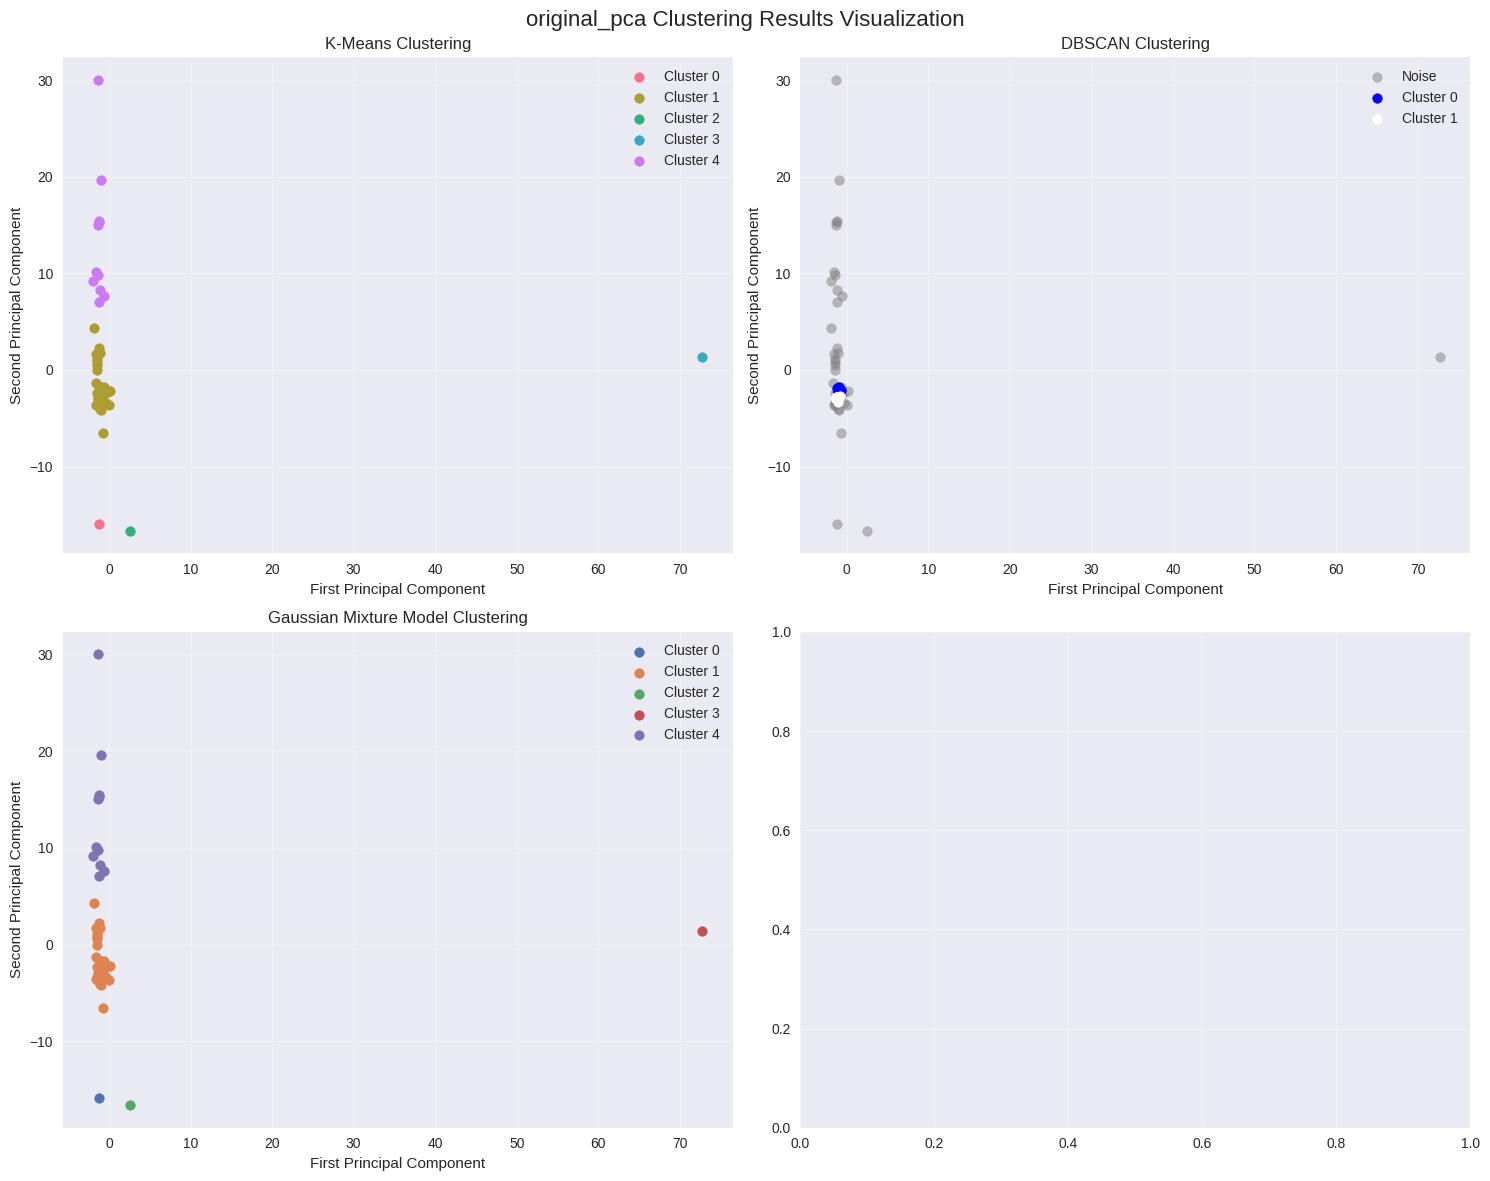


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 40.6554
Silhouette Score: 0.7059459549686
Davies-Bouldin Score: 0.48399841215736306
Adjusted Rand Score: -0.01072396952529791

Cluster Sizes:
Cluster 0: 1 points
Cluster 1: 56 points
Cluster 2: 1 points
Cluster 3: 1 points
Cluster 4: 11 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 26.7574
Silhouette Score: 0.5461208406422737
Davies-Bouldin Score: 0.6242030546588219
Adjusted Rand Score: -0.018572732866244567

Cluster Sizes:
Cluster 0: 16 points
Cluster 1: 11 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 40.6554
Silhouette Score: 0.7059459549686
Davies-Bouldin Score: 0.48399841215736306
Adjusted Rand Score: -0.01072396952529791

Cluster Sizes:
Cluster 0: 1 points
Cluster 1: 56 points
Cluster 2: 1 points
Cluster 3: 1 points
Cluster 4: 11 points

PCA Explained Variance Ratio:
PC1: 8.74%
PC2: 5.49%
PC3: 4.84%
PC4: 4.68%
PC5: 3.56%
Total Variance Explained (first 10

In [153]:
# Running pipeline 
results_original_pca  = clustering_pipeline_all(original_pca,  pca_data_name='pca_data_original_pca ', 
                                                  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_original_pca, title_prefix='original_pca ')
print_clustering_metrics(results_original_pca )

uniques_23_OLS (300+ features):
K-means: Silhouette Score of 0.685, Davies-Bouldin of 0.514
Cluster sizes are quite imbalanced (53, 3, 3, 5, 6 points)
PCA explains 37% of variance (19.95% PC1, 17.05% PC2)

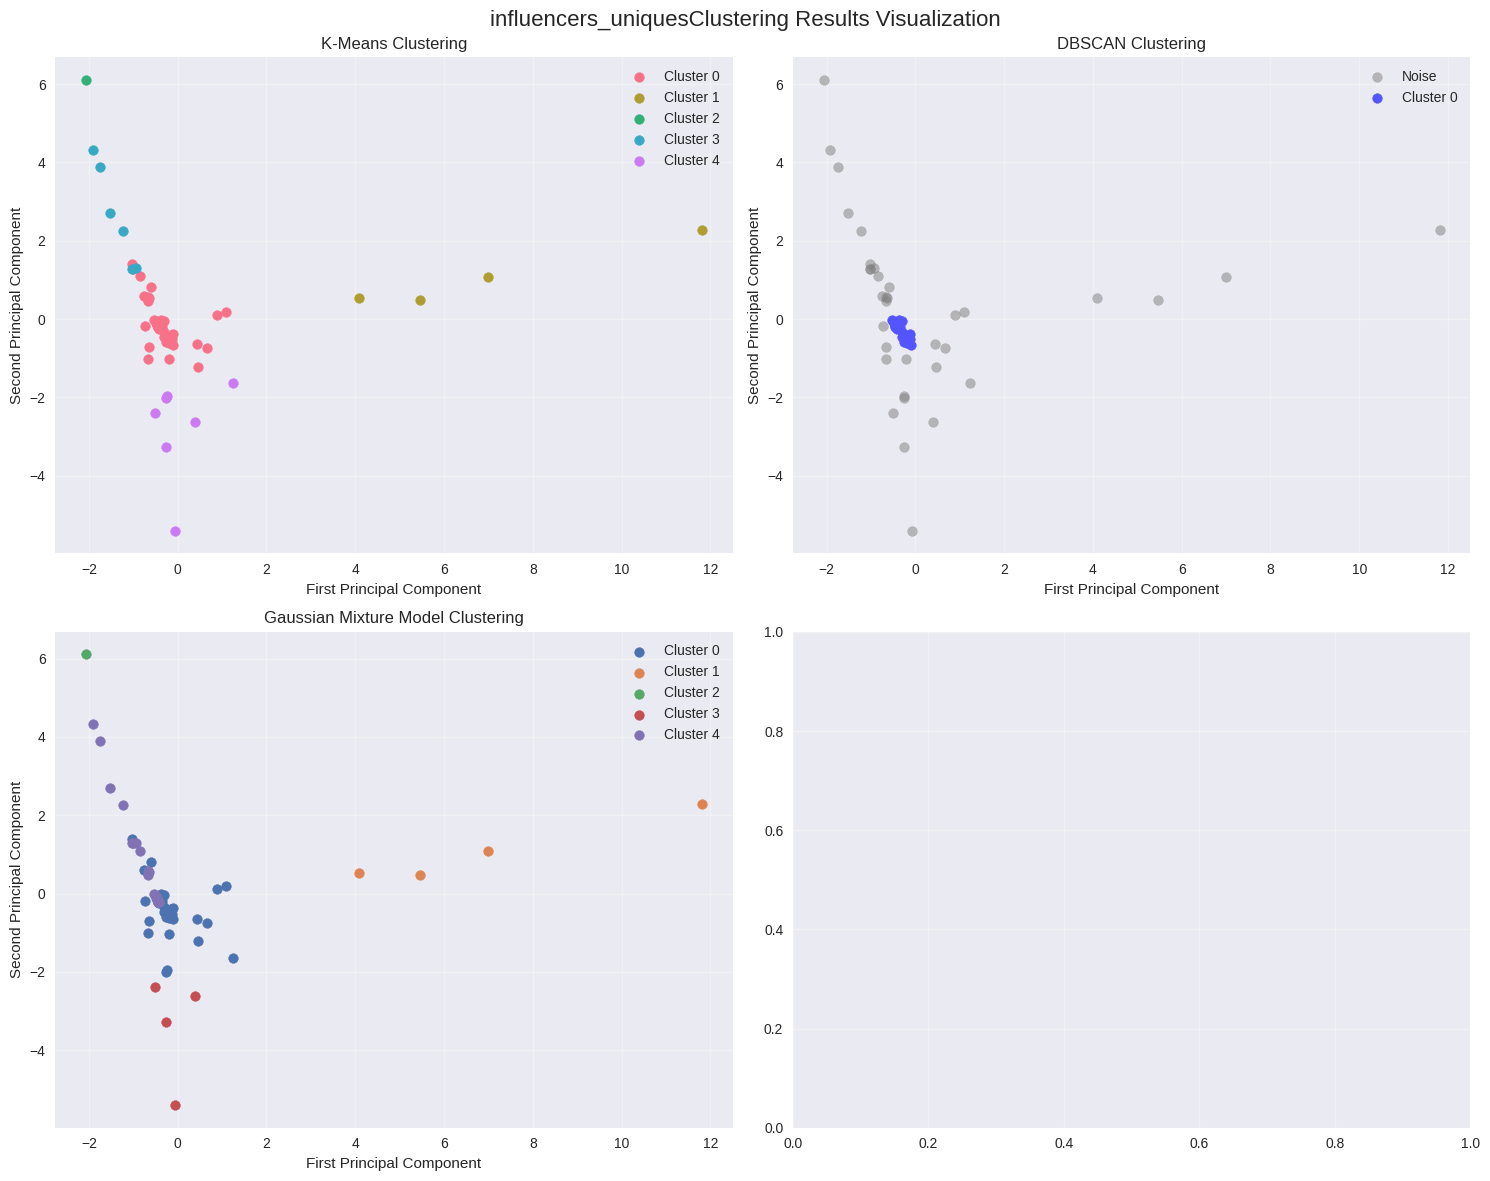


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 7.0222
Silhouette Score: 0.5666412492892613
Davies-Bouldin Score: 0.6056853771340288
Adjusted Rand Score: 0.21661164658713974

Cluster Sizes:
Cluster 0: 52 points
Cluster 1: 4 points
Cluster 2: 1 points
Cluster 3: 6 points
Cluster 4: 7 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 0.7159
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.1482303018613174

Cluster Sizes:
Cluster 0: 35 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 6.3025
Silhouette Score: 0.09718914461846219
Davies-Bouldin Score: 1.3699916834747552
Adjusted Rand Score: 0.1896639460287056

Cluster Sizes:
Cluster 0: 31 points
Cluster 1: 4 points
Cluster 2: 1 points
Cluster 3: 4 points
Cluster 4: 30 points

PCA Explained Variance Ratio:
PC1: 19.19%
PC2: 12.26%
PC3: 9.11%
PC4: 7.33%
PC5: 6.74%
Total Variance Explained (first 10 PCs): 54.63%


In [154]:
#implementing the algoritms in a part of uniques, the first 50 rows
results_influencers_uniques = clustering_pipeline_all(Influencers_uniques,  pca_data_name='pca_data_influencers_uniques',
                                                  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_influencers_uniques, title_prefix='influencers_uniques')
print_clustering_metrics(results_influencers_uniques)

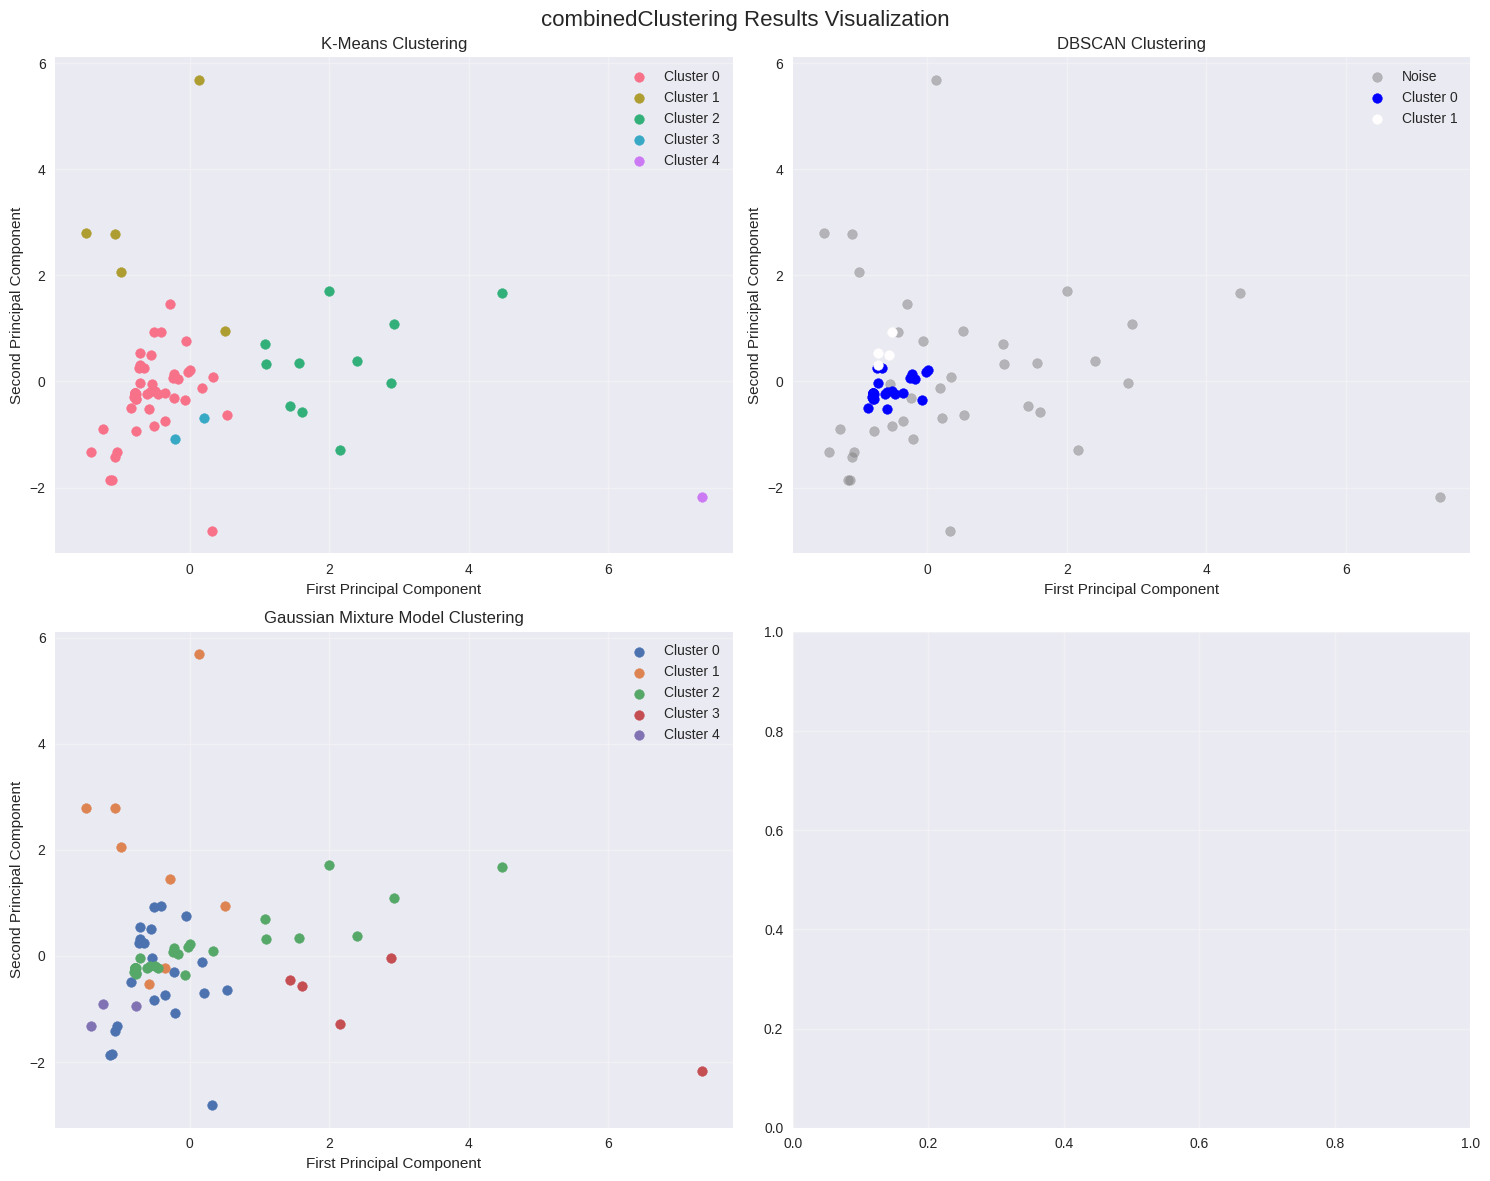


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 3.6096
Silhouette Score: 0.45548951459610093
Davies-Bouldin Score: 0.7502783320745683
Adjusted Rand Score: 0.04239836665946622

Cluster Sizes:
Cluster 0: 51 points
Cluster 1: 5 points
Cluster 2: 11 points
Cluster 3: 2 points
Cluster 4: 1 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 0.7511
Silhouette Score: 0.4261447994293006
Davies-Bouldin Score: 0.8462618797076674
Adjusted Rand Score: 0.05675029275747772

Cluster Sizes:
Cluster 0: 29 points
Cluster 1: 4 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 3.9396
Silhouette Score: 0.12651320501790322
Davies-Bouldin Score: 1.7938939696022096
Adjusted Rand Score: 0.013464424368688912

Cluster Sizes:
Cluster 0: 22 points
Cluster 1: 8 points
Cluster 2: 32 points
Cluster 3: 5 points
Cluster 4: 3 points

PCA Explained Variance Ratio:
PC1: 20.45%
PC2: 14.31%
PC3: 11.56%
PC4: 10.53%
PC5: 10.08%
Total Variance Explained (firs

In [155]:
#implementing the algoritms in a part of uniques, the first 50 rows
# Running pipeline 
results_combined = clustering_pipeline_all(combined,  pca_data_name='pca_data_combined',
                                                  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_combined, title_prefix='combined')
print_clustering_metrics(results_combined)

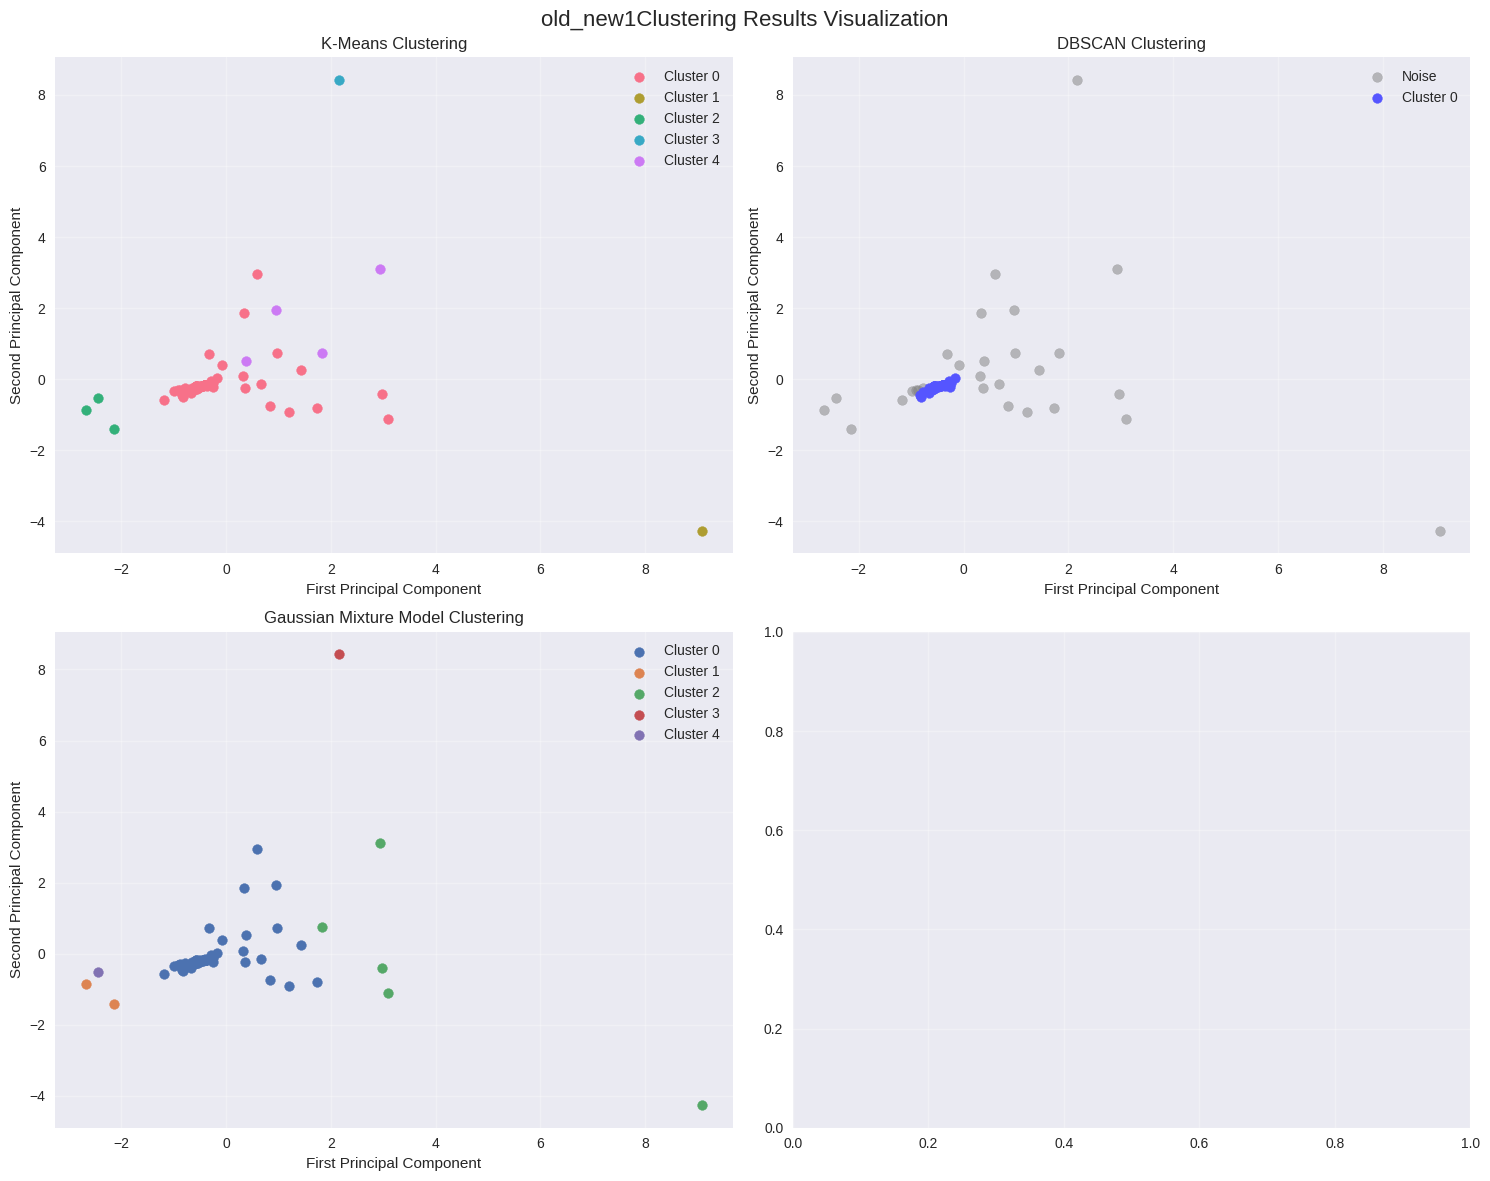


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 6.6949
Silhouette Score: 0.6250441254270628
Davies-Bouldin Score: 0.7040222043418188
Adjusted Rand Score: 0.009759190985449142

Cluster Sizes:
Cluster 0: 61 points
Cluster 1: 1 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 4 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 1.6668
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.09698554576697462

Cluster Sizes:
Cluster 0: 42 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 7.5963
Silhouette Score: 0.6393174777277574
Davies-Bouldin Score: 0.7160789151794396
Adjusted Rand Score: 0.04020358658748029

Cluster Sizes:
Cluster 0: 61 points
Cluster 1: 2 points
Cluster 2: 5 points
Cluster 3: 1 points
Cluster 4: 1 points

PCA Explained Variance Ratio:
PC1: 15.25%
PC2: 12.01%
PC3: 11.34%
PC4: 9.15%
PC5: 8.25%
Total Variance Explained (first 10 PCs): 56.01%


In [156]:
# Running pipeline 
results_old_new1 = clustering_pipeline_all(old_new1 ,  pca_data_name='pca_data_old_new1', 
                                                   n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_old_new1, title_prefix='old_new1')
print_clustering_metrics(results_old_new1)

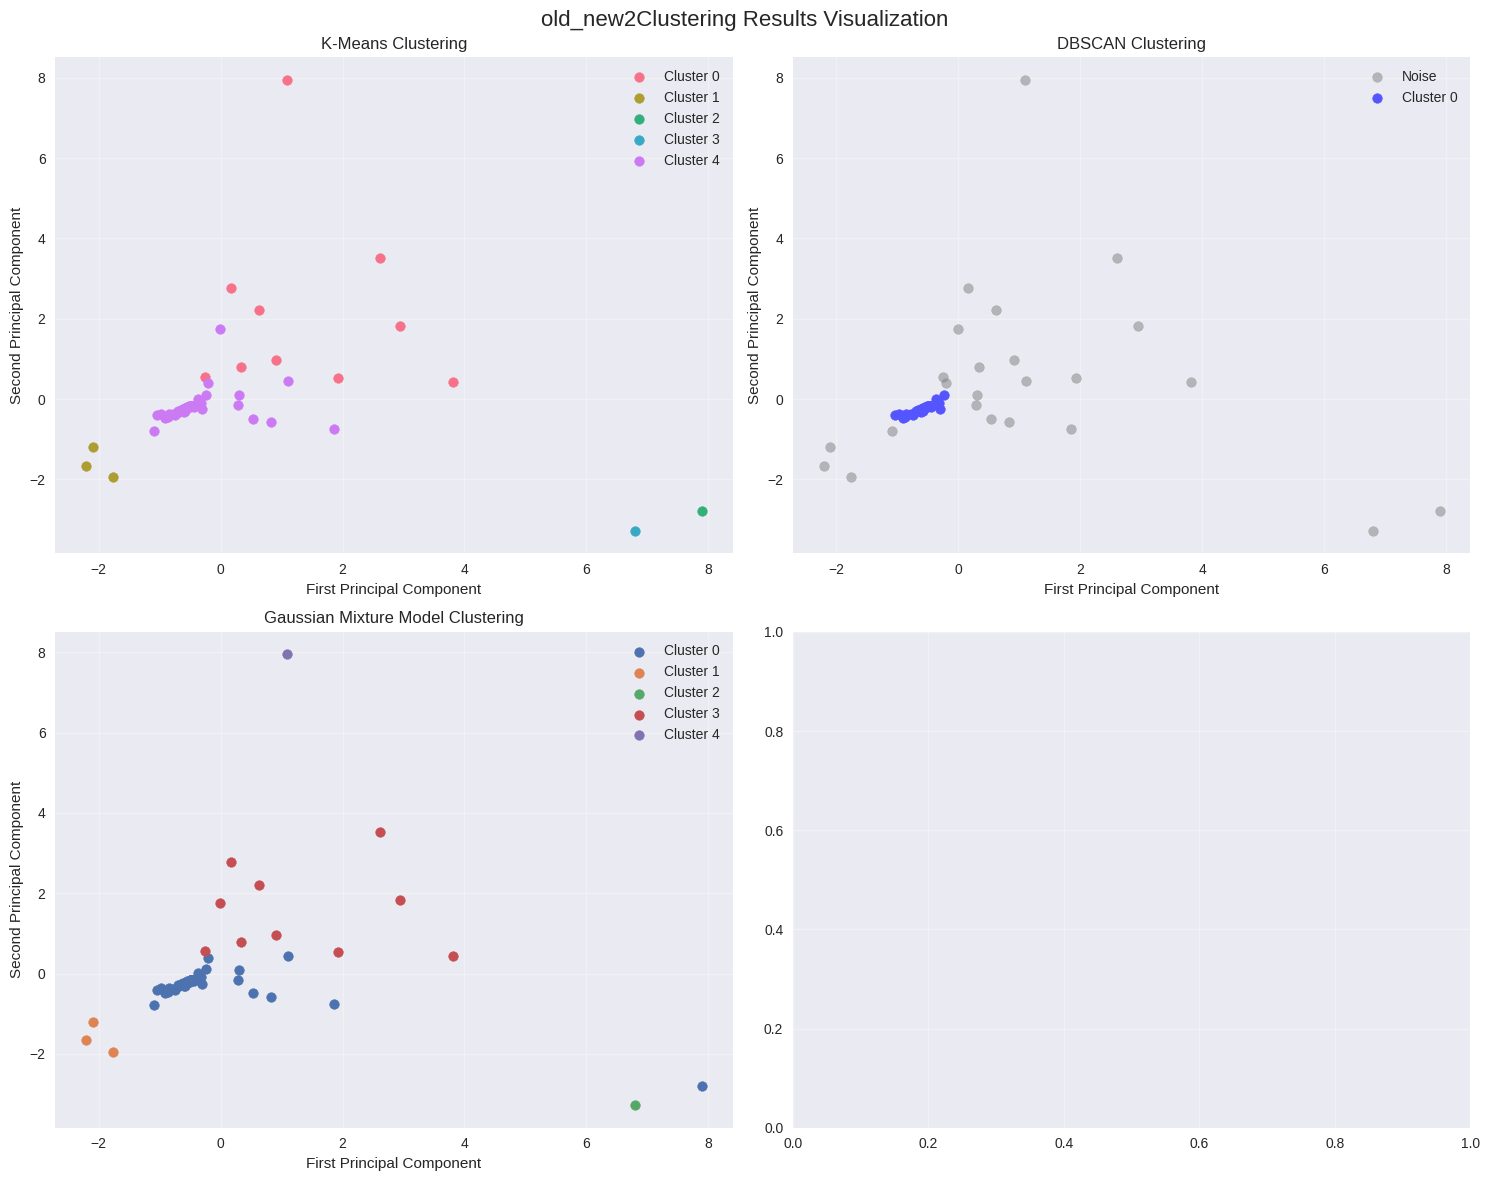


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 7.2917
Silhouette Score: 0.6473281674598893
Davies-Bouldin Score: 0.669314961831618
Adjusted Rand Score: 0.06969698987303004

Cluster Sizes:
Cluster 0: 10 points
Cluster 1: 3 points
Cluster 2: 1 points
Cluster 3: 1 points
Cluster 4: 55 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 2.1133
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.08704075278488894

Cluster Sizes:
Cluster 0: 46 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 7.0768
Silhouette Score: 0.5993913471513231
Davies-Bouldin Score: 0.6323922341030952
Adjusted Rand Score: 0.045195182198904074

Cluster Sizes:
Cluster 0: 55 points
Cluster 1: 3 points
Cluster 2: 1 points
Cluster 3: 10 points
Cluster 4: 1 points

PCA Explained Variance Ratio:
PC1: 15.22%
PC2: 10.81%
PC3: 10.04%
PC4: 8.91%
PC5: 8.38%
Total Variance Explained (first 10 PCs): 53.35%


In [157]:
# Running pipeline 
results_old_new2 = clustering_pipeline_all(old_new2 ,  pca_data_name='pca_data_old_new2', 
                                                   n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_old_new2, title_prefix='old_new2')
print_clustering_metrics(results_old_new2)

In [164]:
# umpack data from results
pca_data = results_Influencers_OLS[f'pca_data_Influencers_OLS']  
scaled_data = results_Influencers_OLS['scaled_data']

# Now create the 3D plot
pc1 = pca_data[:, 0]
pc2 = pca_data[:, 1]
pc3 = pca_data[:, 2]

# Rest of your plotting code
fig = go.Figure(data=[
    go.Scatter3d(
        x=pc1,
        y=pc2,
        z=pc3,
        mode='markers',
        marker=dict(
            size=5,
            color=Influencers_OLS['Category'],
            colorscale='Viridis',
            opacity=0.8
        ),
        text=Influencers_OLS['Category']
    )
])

# Set plot title and axis labels
fig.update_layout(
    title='Interactive 3D PCA Visualization',
    scene=dict(
        xaxis_title='PCA Dimension 1',
        yaxis_title='PCA Dimension 2',
        zaxis_title='PCA Dimension 3'
    ))

fig.show()

Upon inspection of the influencers_OLS with the clusters associated to the label on the PCA_RF_FImportance notebook, there is a consistent pattern and it is possible to distinguish three different regions on the exact place the categories are.  category 1 is a v shape that is intop of cat 2 which is in the middle and 3 form a lineal regression bewen 1 and 2 pca, so together form a y shape. it has a clear differenciation and I can see that cluster 1 is same as cat 3, cluster 2, 3 and 0 are cat 1 and that cluster 4 is cat 2. with no visual overlappings, unlikely with my labels which got at the end of the regression line of 3 an overlaping with the shape of the v. So if we were to distribute the cluster in this fashion, would be possible to say that the clustering is revealing consistent groupings that align with the original categorization:  

Category 1: Comprises clusters 0, 2, 3  (total 7 points)  
Category 2: Corresponds to cluster 4    (10 points)  
Category 3: Matches cluster 1           (53 points)  
The fact that there is a persistent structure on the shapes of all the dataframes 

Ultimately PCA primarily captures linear variance and might not effectively group data by absolute values. It's more about capturing directional variance and relationships rather than precise value clustering. The method projects data onto principal components that maximize variance, which doesn't necessarily mean it's capturing granular value-based distinctions


the principal components are mathematical combinations of the original features. It is possible to try to "invert" the PCA transformation to understand which original features are most responsible for the observed clustering patterns.
One approach would be to examine the PCA loading vectors or the contribution of each feature to the principal components. This could help identify the key underlying characteristics that are driving the separation of the data points. Moreover the cluster boundaries identified by the clustering algorithms are not fixed, static regions. They depend on the distribution of the data points and the specific parameters of the clustering methods. This means that the cluster assignments for individual data points may change if the clustering is performed again with different parameters or on a different dataset. The clustering results provide insights into the overall structure of the data, but the specific cluster boundaries are not guaranteed to be static or definitive.

The PCA loading vectors represent the coefficients that define each principal component. They indicate the relative importance or contribution of each original feature to the corresponding principal component.
By analyzing the loading vectors, it is possible to understand which of the original features are most influential in driving the separation of the data points along the different principal components. Which is very combinient because I am about to decide the selected data from each one of the dfs Influencers_OLS, OLS_all and uniques_23_OLS. By loading the vectors and identifying the original variables that more contribute to the separation, it would help with the selection of the selected genera to implement the cross examination with the physicochemical variables. With this loadings dataframe it is possible to  analyse the relationship with the original features across the principal components, by: higher absolute values = feature importance or features that contrute the most to the separation of the data points. By understand the dimension of the PCAs, then similar loading size hint similar aspects of the data or sinergistic effects?. By connecting clusters loading vectors to the clustering patterns and features, to know which are the most relevant features. 

In [165]:
def calculate_and_analyze_pca_loadings(df, pca, scaled_data_key, output_prefix):
    """
    Calculate and analyze PCA loadings for a given dataset.
    
    Parameters:
    df (pandas.DataFrame): The original DataFrame.
    pca (sklearn.decomposition.PCA): The PCA object from a previous analysis.
    scaled_data_key (str): The key in the results dictionary that holds the scaled data.
    output_prefix (str): A prefix for the output variables to ensure uniqueness.
    
    Returns:
    A dictionary containing the following keys:
    - f"{output_prefix}_loadings_df": The DataFrame of loading vectors.
    - f"{output_prefix}_top_loadings": A dictionary of top contributors for each principal component.
    """
    # Get the loading vectors
    loadings = pca.components_.T
    
    # Create a DataFrame with the loading vectors
    loadings_df = pd.DataFrame(loadings, 
                              index=df.columns[1:], 
                              columns=[f'PC{i+1}' for i in range(loadings.shape[1])])
       
    # Identify top contributors to each principal component
    def get_top_loadings(loadings_df, n_top=10):
        top_loadings = {}
        for col in loadings_df.columns:
            top_loadings[col] = loadings_df[col].abs().nlargest(n_top)
        return top_loadings
    
    top_loadings = get_top_loadings(loadings_df)
    
    # Store the results in a dictionary
    results = {
        f"{output_prefix}_loadings_df": loadings_df,
        f"{output_prefix}_top_loadings": top_loadings
    }
    
    return results

### Heatmap visualisation for PCA loadings
Here the relationships between features and components are visualised and highlight the absolute values of the loading vectors, as they represent the magnitude of feature contributions.

In [166]:
def plot_top_pca_loadings(top_loadings, output_prefix):
    """
    Create a heatmap visualization for the top PCA loadings.
    
    Parameters:
    - top_loadings (dict): A dictionary where the keys are the principal component names
                          and the values are Series containing the top contributing features.
    - output_prefix (str): A prefix for the output file name.
    """
    # Convert the top_loadings dictionary to a DataFrame
    top_loadings_df = pd.concat([loadings.rename(pc) for pc, loadings in top_loadings.items()], axis=1)
    
    # Ensure proper labels and formatting
    top_loadings_df.index.name = 'Feature'
    top_loadings_df.columns.name = 'Principal Component'
    
    # Plot a heatmap for top loadings
    plt.figure(figsize=(8, 6))
    sns.heatmap(top_loadings_df,annot=True, cmap="coolwarm", center=0, cbar_kws={'label': 'Loading Magnitude'})
    plt.title("Top PCA Loadings (10 Features per Component)")
    plt.xlabel("Principal Components")
    plt.ylabel("Top Contributing Features")
    plt.tight_layout()
    plt.savefig(f"{output_prefix}_top_pca_loadings.png", dpi=300)
    plt.show()

Calling the function to calculate and analyse the pca loadings for the dfs
## Pca Loadings for the dfs

Explained Variance Ratio: [0.19122825 0.1640954  0.10924184 0.0915163  0.06725806]
Cumulative Variance Ratio: [0.19122825 0.35532365 0.46456549 0.55608179 0.62333985]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
725  0.3852  0.0133  0.0778  0.0580 -0.1560
871 -0.0639  0.4981  0.2586 -0.1095  0.0013
214 -0.0865 -0.1238  0.2747  0.1622 -0.4173
351  0.2767 -0.0060  0.0575 -0.0500  0.0493
23   0.4812  0.0266  0.1047  0.0583 -0.0191
91  -0.0051  0.2152 -0.2902  0.3076  0.1107
863  0.2320  0.0445 -0.1318  0.0041  0.2558
526 -0.0764 -0.1041  0.1865  0.0501 -0.5566
584 -0.0601 -0.0832  0.1729  0.0905 -0.2839
712 -0.0642  0.4990  0.2570 -0.1063  0.0000

Top Contributors to Principal Components:

PC1 Top Contributors:
23    0.4812
565   0.4489
864   0.4102
725   0.3852
351   0.2767
375   0.2663
863   0.2320
229   0.0957
214   0.0865
526   0.0764
Name: PC1, dtype: float64

PC2 Top Contributors:
712   0.4990
871   0.4981
625   0.4972
549   0.2934
91    0.2152
334   0.1610
678   0.

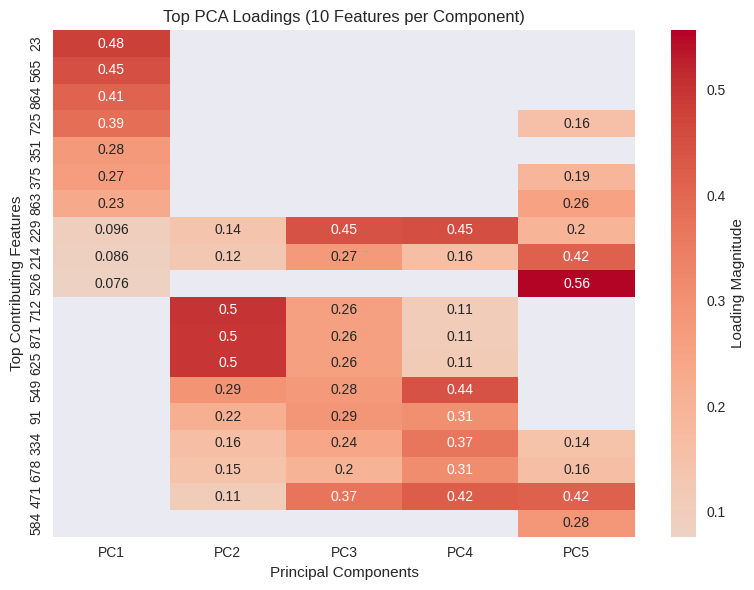

In [167]:
# We taking the data from the previous algoritms results
pca = results_Influencers_OLS['pca']
scaled_data = results_Influencers_OLS['scaled_data']
# Loadings calculation call
results_Influencers_Loadings = calculate_and_analyze_pca_loadings(Influencers_OLS, pca, 'scaled_data', 'Influencers_OLS')

# Access the results
loadings_df = results_Influencers_Loadings['Influencers_OLS_loadings_df']
explained_variance = results_Influencers_OLS['explained_variance']
cumulative_variance = results_Influencers_OLS['cumulative_variance']
top_loadings = results_Influencers_Loadings['Influencers_OLS_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_Influencers_Loadings['Influencers_OLS_top_loadings'],'Influencers_OLS')

Top contributors for PC1 and PC2 are seen. These contributions suggest which original variables drive the variance along each principal axis. Loading values indicate the weight or influence of a feature on a principal component. In for Influencers_OLS feature 23 contributes 0,48 to PC1 and feature 712 contributes 0.499 to PC2.
When puting 7 components the total explained variance ratio of the first 7 PCs is 74.19%.
Strong contribution from PC1 to PC3. Cumulative explained variance achieves a balance of high dimensionality reduction with a reasonable representation. Total explained variance ratio of the first 7 PCs is 68.38%.
Reduced explained variance suggests the additional features do not significantly improve variance representation. In fact, they dilute the strength of the first PCs.

Explained Variance Ratio: [0.19191792 0.12257866 0.09111236 0.07334613 0.06735438]
Cumulative Variance Ratio: [0.19191792 0.31449658 0.40560894 0.47895507 0.54630946]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
549  0.0248 -0.3650  0.4823 -0.0232  0.1862
526 -0.0874  0.2185  0.0267 -0.1752 -0.0330
864  0.4084  0.0881  0.0459 -0.0225 -0.0919
863  0.2367 -0.1173  0.0654 -0.0343 -0.2873
408 -0.0826  0.1682  0.0748 -0.3803  0.2352
91   0.0176 -0.3470  0.4122 -0.1036 -0.0564
351  0.2742  0.0707 -0.0586  0.0111 -0.1296
214 -0.0998  0.2970  0.1306 -0.0684 -0.0404
229 -0.1109  0.4254  0.4015  0.3501 -0.0565
23   0.4780  0.1150  0.0579 -0.0196  0.0150

Top Contributors to Principal Components:

PC1 Top Contributors:
23    0.4780
565   0.4455
864   0.4084
725   0.3821
351   0.2742
375   0.2657
863   0.2367
229   0.1109
214   0.0998
526   0.0874
Name: PC1, dtype: float64

PC2 Top Contributors:
229   0.4254
549   0.3650
91    0.3470
471   0.3427
214   0.2970
334   0.2607
201   0.

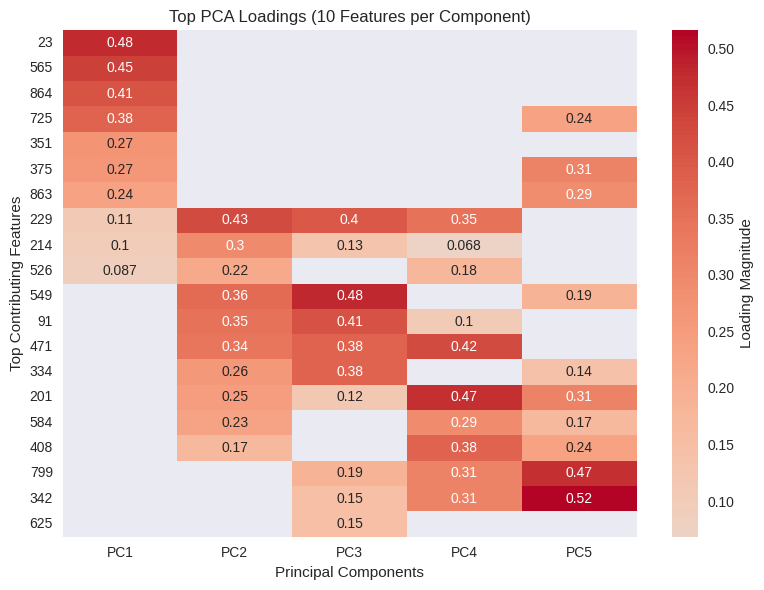

In [168]:
# We taking the data from the previous algoritms results
pca = results_influencers_uniques['pca']
scaled_data = results_influencers_uniques['scaled_data']
# Loadings calculation call
results_influencers_uniques_Loadings = calculate_and_analyze_pca_loadings(Influencers_uniques, pca, 'scaled_data', 'Influencers_uniques')

# Access the results
loadings_df = results_influencers_uniques_Loadings['Influencers_uniques_loadings_df']
explained_variance = results_influencers_uniques['explained_variance']
cumulative_variance = results_influencers_uniques['cumulative_variance']
top_loadings = results_influencers_uniques_Loadings['Influencers_uniques_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_influencers_uniques_Loadings['Influencers_uniques_top_loadings'],'Influencers_uniques')

Explained Variance Ratio: [0.087413   0.05488335 0.04842478 0.04677613 0.03559098]
Cumulative Variance Ratio: [0.087413   0.14229635 0.19072113 0.23749726 0.27308824]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
140 -0.0040 -0.0156 -0.0135 -0.0089 -0.0050
575 -0.0049 -0.0238 -0.0201 -0.0165 -0.0097
687 -0.0053 -0.0176 -0.0165 -0.0111 -0.0101
465 -0.0044  0.0127 -0.0013 -0.0011  0.0340
300 -0.0038 -0.0131 -0.0117 -0.0072 -0.0045
529 -0.0029 -0.0060 -0.0060 -0.0048 -0.0010
609 -0.0048 -0.0230 -0.0200 -0.0159 -0.0092
564 -0.0028  0.0000 -0.0050 -0.0033  0.0057
250 -0.0034 -0.0130 -0.0105 -0.0080 -0.0052
474 -0.0037 -0.0131 -0.0119 -0.0072 -0.0039

Top Contributors to Principal Components:

PC1 Top Contributors:
787   0.1138
817   0.1138
819   0.1137
283   0.1137
71    0.1137
837   0.1137
796   0.1137
56    0.1137
700   0.1137
791   0.1137
Name: PC1, dtype: float64

PC2 Top Contributors:
180   0.1239
616   0.1239
483   0.1146
659   0.1116
45    0.1109
163   0.1062
686   0.

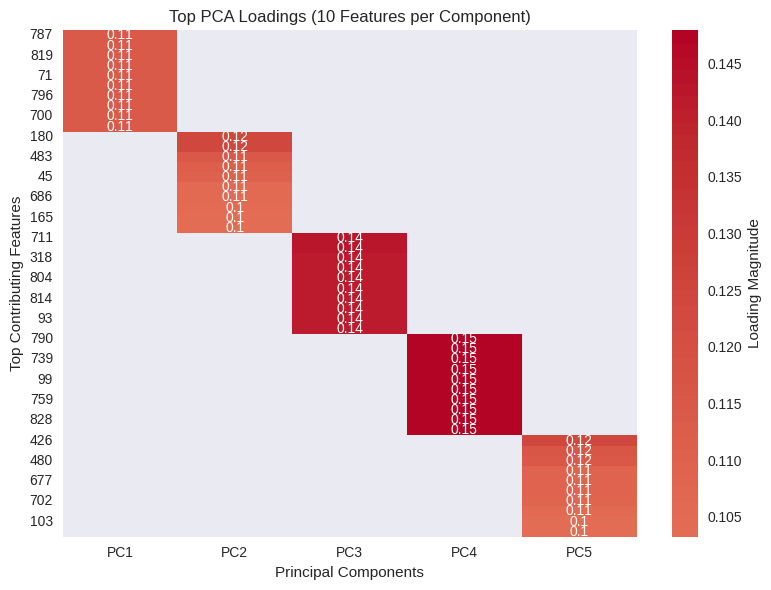

In [169]:
# We taking the data from the previous algoritms results
pca = results_original_pca['pca']
scaled_data = results_original_pca['scaled_data']
# Loadings calculation call
results_original_pca_Loadings = calculate_and_analyze_pca_loadings(original_pca, pca, 'scaled_data', 'original_pca')

# Access the results
loadings_df = results_original_pca_Loadings['original_pca_loadings_df']
explained_variance = results_original_pca['explained_variance']
cumulative_variance = results_original_pca['cumulative_variance']
top_loadings = results_original_pca_Loadings['original_pca_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_original_pca_Loadings['original_pca_top_loadings'],'original_pca')

Explained Variance Ratio: [0.20451448 0.14308491 0.11559833 0.10527208 0.10079712]
Cumulative Variance Ratio: [0.20451448 0.34759939 0.46319771 0.56846979 0.6692669 ]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
549 -0.0489  0.6106 -0.1623  0.0203 -0.1007
371 -0.1018  0.4152 -0.2749  0.5022  0.2534
110 -0.1036 -0.4057 -0.5156 -0.3066 -0.1642
561  0.0313 -0.1116  0.4306  0.4110 -0.6539
526  0.3820 -0.0787  0.2197  0.2183  0.0689
354 -0.1169 -0.1678  0.4538  0.0270  0.6362
572  0.4593  0.0874  0.1488 -0.3728  0.1270
18   0.3493  0.4236  0.1577 -0.4159 -0.1664
214  0.5151 -0.2312 -0.2111  0.2380  0.0203
323  0.4665 -0.0536 -0.3180  0.2597  0.1322

Top Contributors to Principal Components:

PC1 Top Contributors:
214   0.5151
323   0.4665
572   0.4593
526   0.3820
18    0.3493
354   0.1169
110   0.1036
371   0.1018
549   0.0489
561   0.0313
Name: PC1, dtype: float64

PC2 Top Contributors:
549   0.6106
18    0.4236
371   0.4152
110   0.4057
214   0.2312
354   0.1678
561   0.

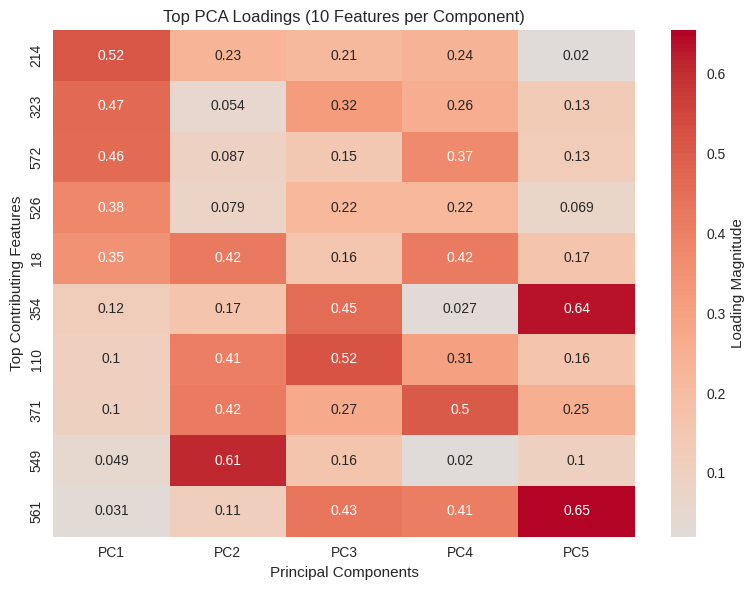

In [170]:
# We taking the data from the previous algoritms results
pca = results_combined['pca']
scaled_data = results_combined['scaled_data']
# Loadings calculation call
results_combined_Loadings = calculate_and_analyze_pca_loadings(combined, pca, 'scaled_data', 'combined')

# Access the results
loadings_df = results_combined_Loadings['combined_loadings_df']
explained_variance = results_combined['explained_variance']
cumulative_variance = results_combined['cumulative_variance']
top_loadings = results_combined_Loadings['combined_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_combined_Loadings['combined_top_loadings'],'combined')

#### Adjusted Rand Index (ARI):
Here the quality of clustering (e.g., KMeans) is evaluated against true labels. ARI measures agreement between predicted and true clusters, adjusting for chance. As said previously the clusters seem to be linked to the categories as pca notbeokk so we going to map the back and try the index again

In [171]:
# Cluster-to-category mapping 
cluster_to_category = {
    0: 3,  # Cluster 0 → Category 3
    1: 1,  # Cluster 2 → Category 1
    2: 1,  # Cluster 3 → Category 1
    3: 1,  # Cluster 4 → Category 2
    4: 2   # Cluster 1 → Category 3
}

# Apply mapping to predicted cluster labels
mapped_labels = np.array([cluster_to_category[label] for label in results_Influencers_OLS['kmeans']['cluster_labels']]) #kmean, dbscan,

# Recalculate ARI
true_labels = Influencers_OLS['Category']
adjusted_ari = adjusted_rand_score(true_labels, mapped_labels)
print(f"Adjusted ARI after remapping: {adjusted_ari}")

Adjusted ARI after remapping: 0.1886182278697579


## t-SNE for Visualization
t-SNE is a non-linear dimensionality reduction technique that is particularly effective for visualizing high-dimensional data in 2D or 3D. It often preserves local structure better than PCA

In [172]:
def tsne_visualization(scaled_data):
    """
    Visualizes data using t-SNE.
    
    Parameters:
    - df: Scaled DataFrame or numpy array (features only).
    - labels: Cluster or category labels to color-code.
    - perplexity: Perplexity for t-SNE (default=30).
    - n_components: Number of components for t-SNE (default=2).
    - random_state: Random seed for reproducibility.
    """
    # Apply t-SNE
    tsne = TSNE(n_components=3, perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(scaled_data)

    # Plot t-SNE results
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=true_labels, cmap='viridis', s=50, alpha=0.7)
    plt.colorbar(label='True Labels')
    plt.title("t-SNE Visualization")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/tmp/ipykernel_1305/154101893.py:19: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



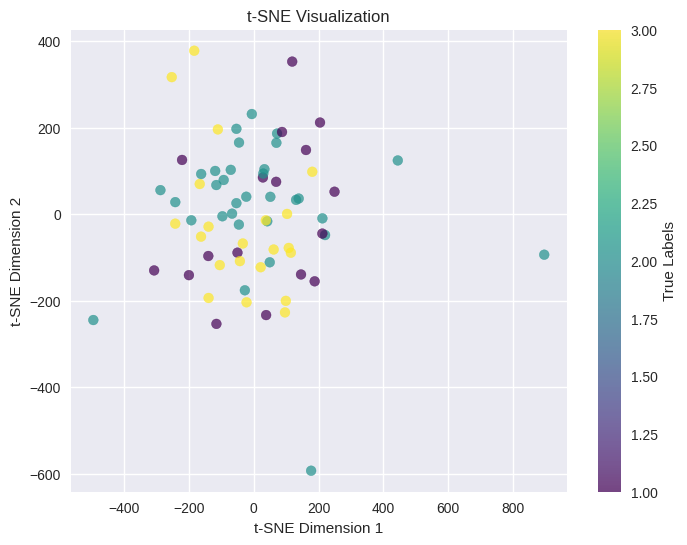

In [174]:
# Visualising the implementation
scaled_data = results_influencers_uniques['scaled_data']
tsne_visualization(scaled_data)

## UMAP for Visualization
UMAP (Uniform Manifold Approximation and Projection) is another excellent method for non-linear dimensionality reduction.

In [178]:
def umap_visualization(df, scaled_data, label_column='Category', colors=['green', 'orange', 'red'], 
                      n_neighbors=10, min_dist=0.1):
    """
    Visualizes data using UMAP with custom colors.

    Parameters:
    - scaled_data: Scaled DataFrame or numpy array (features only).
    - labels: Cluster or category labels for color-coding.
    - categories: List of category values to match labels.
    - colors: List of colors corresponding to each category.
    - n_neighbors: Number of neighbors for UMAP (default=15).
    - min_dist: Minimum distance between points (default=0.1).
    
    Returns:
    - None (Displays a plot)
    """
    # Get category labels from the DataFrame
    labels = df[label_column].values

    # Apply UMAP
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=42)
    umap_results = umap_reducer.fit_transform(scaled_data)

    # Create a mapping from labels to colors
    label_color_map = {category: color for category, color in zip(categories, colors)}
    mapped_colors = [label_color_map[label] for label in labels]
   
    plt.figure(figsize=(8, 6))
    plt.scatter(
        umap_results[:, 0], umap_results[:, 1],
        c=mapped_colors, alpha=0.8, s=50
    )
    plt.title('UMAP Visualization with Custom Colors')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    # Plotting

    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=10, label=f'Category {category}')
               for category, color in zip(categories, colors)]
    plt.legend(handles=handles, title='Category', loc='best')

    plt.show()

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



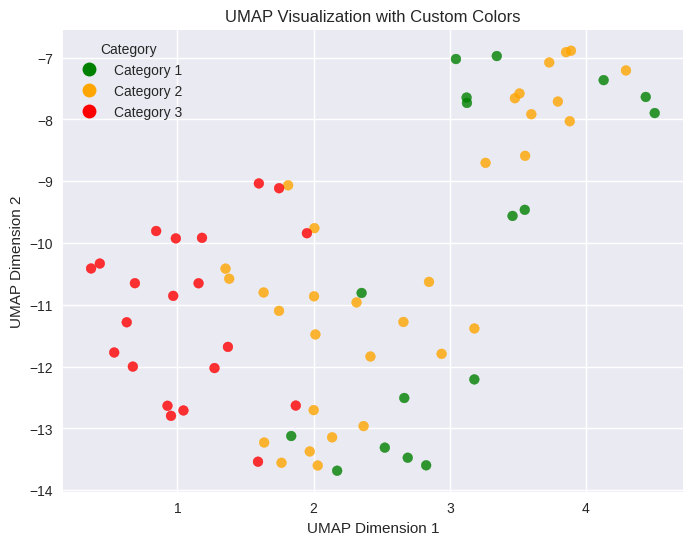

In [186]:
scaled_data = results_Influencers_OLS['scaled_data']
# Extract category labels
category_labels = Influencers_OLS['Category'].values

# Calling the function
umap_visualization(Influencers_OLS, scaled_data, label_column='Category', colors=colors, n_neighbors=10, min_dist=0.1)

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



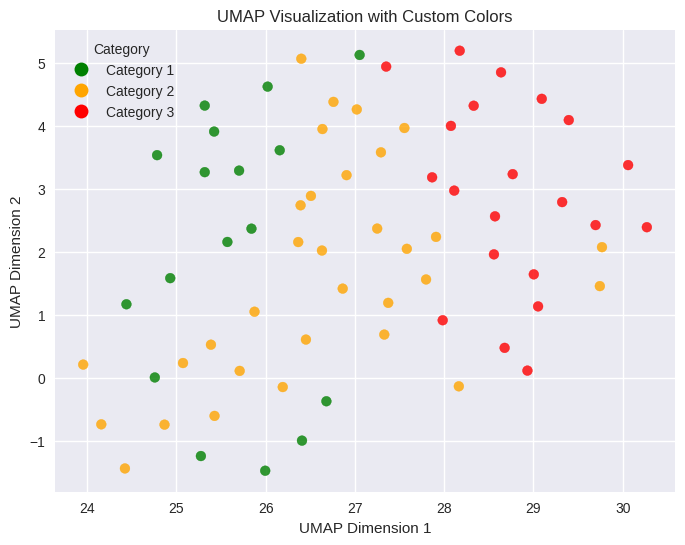

In [211]:
scaled_data = results_Influencers_OLS['scaled_data']
# Extract category labels
category_labels = Influencers_OLS['Category'].values

# Calling the function
umap_visualization(Influencers_OLS, scaled_data, label_column='Category', colors=colors, n_neighbors=20, min_dist=0.70)

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



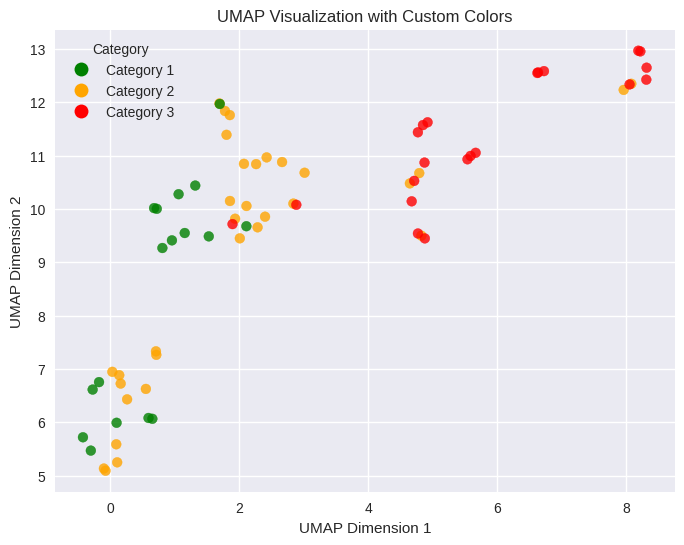

In [215]:
scaled_data = results_Influencers_OLS['scaled_data']
# Extract category labels
category_labels = Influencers_OLS['Category'].values

# Calling the function
umap_visualization(Influencers_OLS, scaled_data, label_column='Category', colors=colors, n_neighbors=4, min_dist=0.05)

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



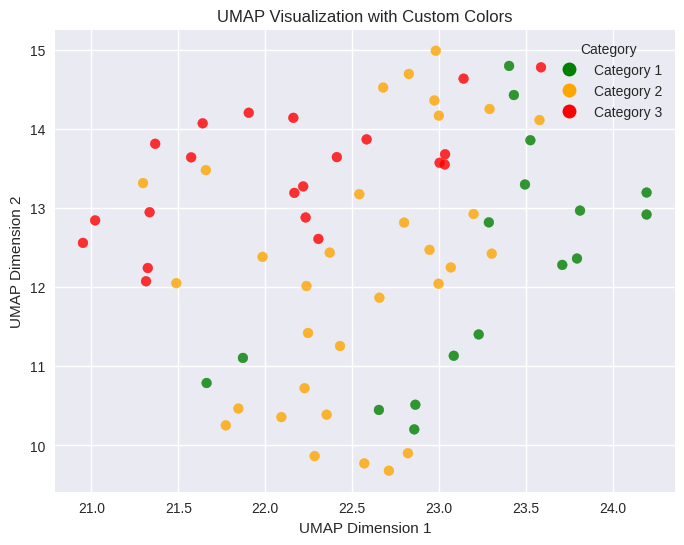

In [217]:
scaled_data = results_Influencers_OLS['scaled_data']
# Extract category labels
category_labels = Influencers_OLS['Category'].values

# Calling the function
umap_visualization(Influencers_OLS, scaled_data, label_column='Category', colors=colors, n_neighbors=35, min_dist=0.05)

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



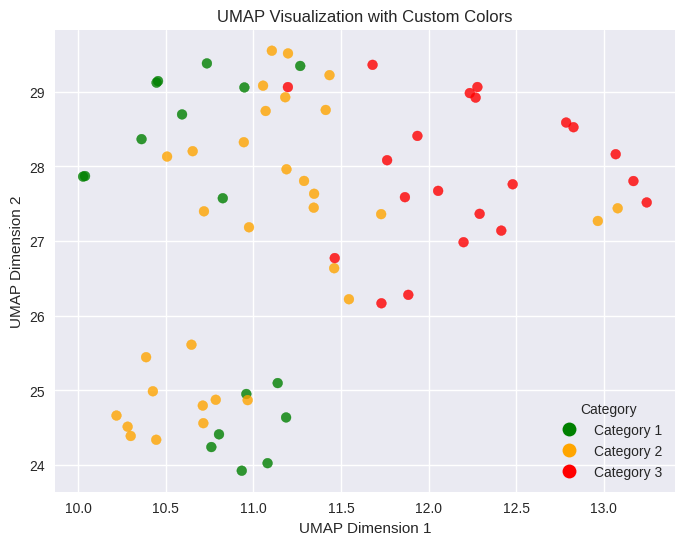

In [220]:
scaled_data = results_Influencers_OLS['scaled_data']
# Extract category labels
category_labels = Influencers_OLS['Category'].values

# Calling the function
umap_visualization(Influencers_OLS, scaled_data, label_column='Category', colors=colors, n_neighbors=13, min_dist=0.005)

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



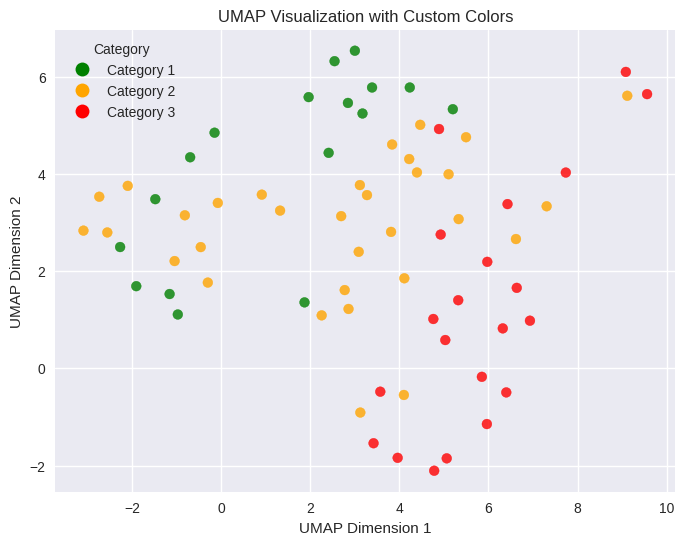

In [195]:
scaled_data = results_Influencers_OLS['scaled_data']
# Extract category labels
category_labels = Influencers_OLS['Category'].values

# Calling the function
umap_visualization(Influencers_OLS, scaled_data, label_column='Category', colors=colors, n_neighbors=4, min_dist=0.7)

**Influencers_OLS shows**: More distinct separation between categories,
Category 3 (red) tends to cluster on the right side
Category 1 (green) and 2 (orange) have some overlap but show patterns

**Influencers_uniques shows**: Different spatial arrangement, better vertical separation of Category 3. 
More spread out distribution overall
**Combined/Merged** shows: More mixing between categories, some local clustering but less global structure, higher dimension 2 values (7-11 range)

The Influencers_OLS visualization appears to show the clearest structure, which aligns with its better classification metrics. This suggests that the feature selection in Influencers_OLS captured more discriminative patterns in the data

In [ ]:
https://www.nature.com/articles/s41529-022-00218-4#data-availability

# Microbiological Analysis Compendium

## Study Context
This study focuses on understanding microbial community structures through advanced statistical and machine learning techniques, specifically examining bacterial genera across different environmental conditions.

## Datasets
### Primary Datasets
1. **Influencers_OLS**: 
   - Filtered data with genera above 0.2% abundance
   - Minimum frequency of 3
   - Selected using Ordinary Least Squares (OLS)

2. **OLS_all**: 
   - Comprehensive dataset with significance selection by OLS

3. **uniques_23_OLS**:
   - Includes unique genera samples
   - Incorporates common genera from categories 2 and 3
   - Underwent OLS significance selection

## Methodological Approach

### Dimensionality Reduction
- **Principal Component Analysis (PCA)**
  - Reduced dataset to principal components
  - Retained approximately 90% of variance
  - Transformed high-dimensional microbiological data

### Clustering Techniques
1. **K-Means Clustering**
   - Fixed number of clusters (5)
   - Identified underlying data structures

2. **DBSCAN**
   - Density-based spatial clustering
   - Detected clusters and potential outliers

3. **Gaussian Mixture Models (GMM)**
   - Captured potential non-linear data structures

## Performance Metrics

### Clustering Evaluation
- **Silhouette Score**: Measures cluster cohesion
- **Davies-Bouldin Index**: Assesses cluster separation
- **Adjusted Rand Index (ARI)**: Compared clustering results with original categories

### Key Performance Insights
- Highest performing dataset: uniques_23_OLS_50
  - Silhouette Score: 0.754
  - Davies-Bouldin Score: 0.298
  - Explained Variance: 49.17%

## Visualization Techniques
1. **PCA Scatter Plots**
2. **t-SNE Visualization**
3. **UMAP**
4. **PCA Loadings Heatmap**

## Key Observations
- Clustering algorithms effectively captured inherent data structure
- Persistent patterns across different datasets
- Potential alignment between clustering results and original microbial categories

## Limitations and Considerations
- PCA primarily captures linear variance
- Cluster boundaries are not static
- Loadings represent feature contributions, not absolute distinctions

## Recommended Next Steps
1. Further investigation of top contributing features
2. Correlation with physicochemical parameters
3. Validation of microbial genera distribution

## Conclusion
The analysis reveals complex microbiological community structures, demonstrating the potential of advanced statistical techniques in understanding microbial ecology.